In [7]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path

# Setup (Shape checker)

In [517]:
"""
This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial.
"""

class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                             f'    found {rank}: {shape.numpy()}\n'
                             f'    expected {len(names)}: {names}\n')

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

# The data

In [188]:
def load_data(path):
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    inp = [inp for targ, inp, attribution in pairs]
    targ = [targ for targ, inp, attribution in pairs]

    return targ, inp

In [13]:
"""
translations from http://www.manythings.org/anki/http://www.manythings.org/anki/
"""

path_to_raw_translations = Path("./spa-eng/spa.txt")
targ, inp = load_data(path_to_raw_translations)

In [21]:
inp[-1]

'Un día, me desperté y vi que Dios me había puesto pelo en la cara. Me lo afeité. Al día siguiente, vi que Dios me lo había vuelto a poner en la cara, así que me lo afeité otra vez. Al tercer día, cuando vi que Dios me había puesto pelo en la cara de nuevo, decidí que Dios se saliera con la suya. Por eso tengo barba.'

In [22]:
targ[-1]

"One day, I woke up to find that God had put hair on my face. I shaved it off. The next day, I found that God had put it back on my face, so I shaved it off again. On the third day, when I found that God had put hair back on my face again, I decided to let God have his way. That's why I have a beard."

In [48]:
"""
From these arrays of strings you can create a tf.data.Dataset of strings that shuffles and batches them efficiently:
"""

BATCH_SIZE = 64
BUFFER_SIZE = len(inp)

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE) # from_tensor_slices() performs very similar to zip() when used like this
for tran_pair in list(dataset.as_numpy_iterator())[:10]:
    print(tran_pair)

dataset = dataset.batch(BATCH_SIZE)

(b'Alemania alguna vez fue aliado de Italia.', b'Germany was once an ally of Italy.')
(b'\xc3\x89l habla fluidamente el japon\xc3\xa9s.', b"He's fluent in Japanese.")
(b'D\xc3\xa9jenme decirles una cosa.', b'Let me tell you something.')
(b'T\xc3\xba primero.', b'You go first.')
(b'En esta habitaci\xc3\xb3n hace mucho fr\xc3\xado.', b"It's really cold in this room.")
(b'Nunca me cont\xc3\xb3 usted nada sobre el accidente.', b'You never told me anything about the accident.')
(b'Me gustan las pel\xc3\xadculas.', b'I like movies.')
(b'\xc2\xbfQu\xc3\xa9 sabes sobre \xc3\xa9l?', b'What do you know about him?')
(b'\xc2\xbfEs su libro?', b'Is it your book?')
(b'Tom sigue diciendo que es inocente.', b"Tom keeps saying he's innocent.")


In [63]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:10])
    print()
    print(example_target_batch[:10])

tf.Tensor(
[b'Lucha como un hombre.' b'Tom y Mary cogieron una galleta cada uno.'
 b'Ense\xc3\xb1arle a los ni\xc3\xb1os es m\xc3\xa1s f\xc3\xa1cil que a los adultos.'
 b'\xc2\xbfNo tendr\xc3\xa1s una aguja y algo de hilo?'
 b'Tengo que limpiar el aseo.'
 b'Tom est\xc3\xa1 locamente enamorado de Mary.'
 b'\xc3\x89l hizo el trabajo en dos d\xc3\xadas.' b'Est\xc3\xa1s loco.'
 b'Ella no se present\xc3\xb3 en la fiesta ayer.'
 b'Me pregunto que tienen en com\xc3\xban todos ellos.'], shape=(10,), dtype=string)

tf.Tensor(
[b'Fight like a man.' b'Tom and Mary each took one cookie.'
 b"It's easier to teach children than adults."
 b"Don't you have a needle and some thread?"
 b'I have to clean the bathroom.'
 b'Tom is head over heels in love with Mary.'
 b'He did the work in two days.' b"You're insane."
 b"She didn't show up at the party yesterday."
 b'I wonder what all of them have in common.'], shape=(10,), dtype=string)


In [50]:
"""
Standardization
The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The tensorflow_text package contains a unicode normalize operation:
"""

example_inp = tf.constant("¿Todavía está en casa?")
print(example_inp.numpy())
print(tf_text.normalize_utf8(example_inp, "NFKD").numpy()) # notice how chars like 'í' are replaced with some combo of unicode hex and 'i'. 

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [54]:
def tf_lower_and_split_punct(text):
    # Split accented chars from their accents, and convert text to lowercase.
    text = tf_text.normalize_utf8(text, "NFKD")
    text = tf.strings.lower(text)
    
    # Keep space, a to z, and select punctuation chars.
    text = tf.strings.regex_replace(text, "[^ a-z.?!,¿]", "")
    
    # Add spaces around punctuation (* so punctuation is considered as their own unique tokens instead of unique words, e.g. "done?" to ["done", "?"] instead of ["done?"]).
    text = tf.strings.regex_replace(text, "[.?!,¿]", r" \0 ")
    
    # Strip whitespace.
    text = tf.strings.strip(text)
    
     # Insert sos and eos tokens.
    text = tf.strings.join(["[START]", text, "[END]"], separator=" ")
    return text

In [58]:
print(example_inp.numpy().decode())
print(tf_lower_and_split_punct(example_inp).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [142]:
span_vocab = set()
eng_vocab = set()
for x, y in dataset:
    x = tf_lower_and_split_punct(x)
    for seq in x.numpy():
        for tok in seq.decode().split():
            span_vocab.add(tok)
    y = tf_lower_and_split_punct(y)
    for seq in y.numpy():
        for tok in seq.decode().split():
            eng_vocab.add(tok)

print(f"spanish vocab size: {len(span_vocab)} tokens")
print(f"english vocab size: {len(eng_vocab)} tokens")

spanish vocab size: 26584 words
english vocab size: 14134 words


In [160]:
"""
Text Vectorization
This standardization function will be wrapped up in a tf.keras.layers.TextVectorization layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.
"""

max_vocab_size = 5000

input_text_pre_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

output_text_pre_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

In [161]:
"""
The TextVectorization layer and many other preprocessing layers have an adapt method. 
This method reads one epoch of the training data, and works a lot like Model.fix. 
This adapt method initializes the layer based on the data. Here it determines the vocabulary:
"""

input_text_pre_processor.adapt(inp)
output_text_pre_processor.adapt(targ)

In [162]:
# 1st few words from learned vocabs of preprocessing layers
print(input_text_pre_processor.get_vocabulary()[:11])
print(output_text_pre_processor.get_vocabulary()[:11])

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'no', 'tom', 'a']
['', '[UNK]', '[START]', '[END]', '.', 'i', 'the', 'to', 'you', 'tom', 'a']


In [166]:
"""
Now these layers can convert a batch of strings into a batch of token IDs:
"""

example_tokens = input_text_pre_processor(example_input_batch)
example_tokens[:5, :20]

<tf.Tensor: shape=(5, 17), dtype=int64, numpy=
array([[   2, 3575,   38,   16,  160,    4,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   2,    9,   34,   30, 3962,   23,    1,  242,  185,    4,    3,
           0,    0,    0,    0,    0,    0],
       [   2,    1,   10,   25,  189,   14,   35,  304,    5,   10,   25,
        2998,    4,    3,    0,    0,    0],
       [   2,   13,    8, 1534,   23, 4207,   34,   59,    6, 4106,   12,
           3,    0,    0,    0,    0,    0],
       [   2,   47,    5, 1120,    7,    1,    4,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int64)>

In [176]:
"""
The get_vocabulary method can be used to convert token IDs back to text since token IDs correspond to their idx in vocab:
"""

input_vocab = np.array(input_text_pre_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
print(input_vocab)
print()
print(example_tokens[0].numpy())
print()
print(" ".join(tokens))

['' '[UNK]' '[START]' ... 'compartio' 'comparado' 'comere']

[   2 3575   38   16  160    4    3    0    0    0    0    0    0    0
    0    0    0]

[START] lucha como un hombre . [END]          


Text(0.5, 1.0, 'Mask')

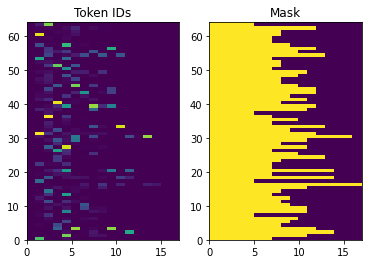

In [185]:
"""
The returned token IDs are zero-padded. This can easily be turned into a mask,
where each row is a sequence and each column represents a token in the sentence
in the form of its ID value.
"""

plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [186]:
example_tokens

<tf.Tensor: shape=(64, 17), dtype=int64, numpy=
array([[   2, 3575,   38, ...,    0,    0,    0],
       [   2,    9,   34, ...,    0,    0,    0],
       [   2,    1,   10, ...,    0,    0,    0],
       ...,
       [   2,    8,   18, ...,    0,    0,    0],
       [   2,   39,   46, ...,    0,    0,    0],
       [   2,  363, 3995, ...,    0,    0,    0]], dtype=int64)>

# The encoder/decoder model

In [241]:
embedding_dim = 256
layer_units = 1024 # num of units for encoder, attention, and decoder layers

In [356]:
"""
The encoder
Start by building the encoder, the blue part of the diagram above.

The encoder:

1) Takes a list of token IDs (from input_text_processor).
2) Looks up an embedding vector for each token (Using a layers.Embedding), meaning we are working at word lvl granularity.
3) Processes the embeddings into a new sequence (Using a layers.GRU).
4) Returns:
        - The processed sequence. This will be passed to the attention head.
        - The internal state. This will be used to initialize the decoder
"""

# For good explaination of diff between RNN layers, cells, and units as well as purpose of return_sequences, and return_state, visit:
# - https://datascience.stackexchange.com/questions/12964/what-is-the-meaning-of-the-number-of-units-in-the-lstm-cell
# - https://www.dlology.com/blog/how-to-use-return_state-or-return_sequences-in-keras/

class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.input_vocab_size = input_vocab_size
        self.enc_units = enc_units
        
        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            input_dim=self.input_vocab_size,
            output_dim=embedding_dim
        )
        
        # The GRU RNN layer processes token vectors sequentially.
        self.gru = tf.keras.layers.GRU(
            units=self.enc_units,
            # Return the process sequence and the internal state
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform"
        )
    
    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        
        # 1. List of token IDs.
        shape_checker(tokens, ("batch", "enc_idx"))
        
        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)
        shape_checker(vectors, ("batch", "enc_idx", "embedding_dim"))
        
        # 3. The GRU processes the seq of embeddings.
        #       output (hidden states) shape: (batch, seq_len, enc_units)
        #       state (cell state) shape: (batch, enc_units)        
        enc_hidden_states, enc_cell_states = self.gru(vectors, initial_state=state)
        shape_checker(enc_hidden_states, ("batch", "enc_idx", "enc_hidden_state_cells"))
        shape_checker(enc_cell_states, ("batch", "enc_hidden_state_cells"))
        
        # 4. Returns the new sequence and its state.
        return enc_hidden_states, enc_cell_states

In [357]:
"""
Testing the encoder
"""

# Convert the input text to tokens.
example_input_tokens = input_text_pre_processor(example_input_batch)
# Encode the input sequence.
encoder = Encoder(
    input_vocab_size=max_vocab_size,
    embedding_dim=embedding_dim,
    enc_units=layer_units
)

example_enc_output, example_enc_state = encoder(examples_tokens)

print(f'Example:\n------------------------------\nInput batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, seq_len): {example_input_tokens.shape}')
print(f'\nEncoder output, shape (batch, seq_len, enc_units_per_layer): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, enc_units_per_layer): {example_enc_state.shape}')

Example:
------------------------------
Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, seq_len): (64, 17)

Encoder output, shape (batch, seq_len, enc_units_per_layer): (64, 17, 1024)
Encoder state, shape (batch, enc_units_per_layer): (64, 1024)


In [311]:
"""
Attention Head

The decoder uses attention to selectively focus on parts of the input sequence. 
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. 
This attention layer is similar to a layers.GlobalAveragePoling1D but the attention layer performs a weighted average.

The equations:
- (eq 4) Calculates the energy scores w/ compatibility function which will be Bahdanau's additive compatibility func (a FFNN basically, also a combine compatibility approach).
- (eq 1) Calculates the attention weights, [alpha]_ts, as a softmax across the encoder's output sequence.
- (eq 2) Calculates the context vector as the weighted sum of the encoder outputs.
"""

class BahdanuaAttention(tf.keras.layers.Layer):
    def __init__(self, additive_attn_units):
        super(BahdanuaAttention, self).__init__()
        
        # For eq. 4, additive compatibility func
        self.W1 = tf.keras.layers.Dense(additive_attn_units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(additive_attn_units, use_bias=False)  
        
        self.additiveAttention = tf.keras.layers.AdditiveAttention()
    
    # Remember key and value are the same in Bahdanua attention based Seq2Seq model,
    # however within this TF implementation the key ("W2 @ hs") is put into a diff represetntion of the from the input value (input seq)
    # due to the additive compat. func.
    
    # Also, in this attention approach the query is a matrix of token vecs (since we consider current target word 
    # and all prev words in target seq) like the keys instead of single vec for only the target token vec.
    
    # dec_idx (t) and enc_idx (s) represent decoder and encoder hidden states at diff time indices. enc_idx will be length of a padded
    # input seq and dec_idx will be length of a padded output seq.
    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ("batch", "dec_idx", "dec_hid_state_cells"))
        shape_checker(value, ("batch", "enc_idx", "enc_hid_state_cells"))
        shape_checker(mask, ("batch", "enc_idx"))
        
        # From eq. 4 "W1 @ ht" (@ being matrix multiplication)
        w1_query = self.W1(query)
        shape_checker(w1_query, ("batch", "dec_idx", "additive_attn_units"))
        
        # From eq. 4 "W2 @ hs" (@ being matrix multiplication)
        w2_key = self.W2(value)
        shape_checker(w2_key, ("batch", "enc_idx", "additive_attn_units"))
        
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool) # If given, the output will be zero at the positions where mask==False.
        value_mask = mask # If given, will apply the mask such that values at positions where mask==False do not contribute to the result.

        context_vectors, attention_weight_dists = self.additiveAttention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True # returns attention weights after softmax dist func in "core" attention model
        )
        # dec_idx is size of tensors' axis 1 because each targ word from 1st to dec_idx-ist will have a context vector (in other 
        # words, a compact attention representation of the input seq) and attention weight dist associated w/ it. Each targ word 
        # pays attention to potentially diff words from input seq based on potentially diff attention weight dists.
        shape_checker(context_vectors, ("batch", "dec_idx", "enc_hid_state_cells")) # each context vec is of length enc_hid_state_cells because it is the "compact" representation of the input seq which will be the same size as enc hidden state at a single timestamp.
        shape_checker(attention_weight_dists, ("batch", "dec_idx", "enc_idx")) # each attention weight dist is of length enc_idx because there is a corresponding weight for each token in input seq
        
        return context_vectors, attention_weight_dists

In [312]:
"""
Testing attention (model) layer

This layer takes 3 inputs:
- The query: This will be generated by the decoder, later.
- The value: This Will be the output of the encoder.
- The mask: To exclude the padding: use (example_input_tokens != 0) would result in a bool tensor of same size as example_input_tokens

The vectorized implementation of the attention layer lets you pass a batch of sequences of query vectors and a batch of sequence of value vectors. The result is:
1) A batch of sequences of resultant context vectors (each the length of the queries).
2) A batch of attention weight dists, with size (query_length, value_length).
"""

attention_layer = BahdanuaAttention(layer_units)

# Later, the decoder will generate this attention query.
example_attention_query = tf.random.normal(shape=[len(example_input_tokens), 2, 10])

# Attend to the encoded tokens:
context_vectors, attention_weight_dists = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_input_tokens != 0)
)

print(f'Context vectors shape: (batch_size, query_seq_length, units):   {context_vectors.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length):   {attention_weight_dists.shape}')

Context vectors shape: (batch_size, query_seq_length, units):   (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length):   (64, 2, 17)


Text(0.5, 1.0, 'Mask')

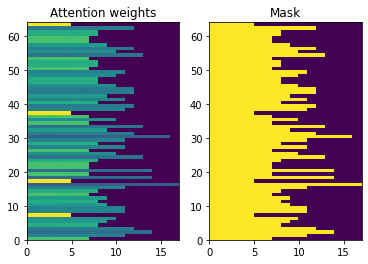

In [313]:
# The attention weights should sum to 1.0 for each sequence.

# Here are the attention weights across the sequences at t=0:

# Because of the small-random initialization the attention weights are all close to 1/(sequence_length). If you zoom in on the weights for a single sequence, you can see that there is some small variation that the model can learn to expand, and exploit.
# In other words, weight dists look like all same values per input seq because model has not been trained.
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_input_tokens != 0)
plt.title('Mask')

<Figure size 432x288 with 0 Axes>

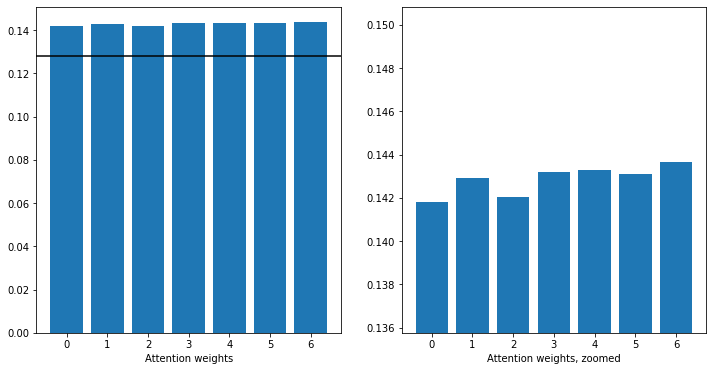

In [286]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [304]:
"""
The decoder

The decoder's job is to generate predictions for the next output token.
1) The decoder receives the complete encoder output (final enc cell state and enc hidden states at all timestamps for input seq).
2) It uses an RNN to keep track of what it has generated so far.
3) It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4) It combines the RNN output and the context vector using Equation 3 (below) to generate the "attention vector".
5) It generates logit predictions for the next token based on the "attention vector".
"""

# The call method for this Decoder layer takes and returns multiple tensors. Organize those into simple container classes (DecoderInput and DecoderOutput):
class DecoderInput(typing.NamedTuple):
    new_tokens: Any   # The last tokens generated. Decoder will be initialized with the "[START]" token.
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding_dim = embedding_dim
        self.output_vocab_size = output_vocab_size
        
        # 1) The embedding layer converts token IDs to vectors.
        self.embedding = tf.keras.layers.Embedding(
            input_dim=self.output_vocab_size,
            output_dim=self.embedding_dim
        )
        
        # 2) The RNN keeps track of whats been generated so far.
        self.gru = tf.keras.layers.GRU(
            units=self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform"
        )
        
        # 3) The RNN output will be the next query for the attention layer.
        self.attention = BahdanuaAttention(self.dec_units)
        
        # 4) Use eq. 3: combine (use FFNN a.k.a. just a dense layer) decoder RNN hidden state w/ context vector to obtain "attention vector"
        self.Wc = tf.keras.layers.Dense(
            units=self.dec_units,
            activation=tf.math.tanh,
            use_bias=False
        )
        
        # 5) This fully connected dense layer produces the logits for each output token from the "attention vector" outputted from the last dense layer in step 4.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)
        
    def call(self,
             inputs: DecoderInput,
             state=None) -> Tuple[DecoderOutput, tf.Tensor]:
        shape_checker = ShapeChecker()
        shape_checker(inputs.new_tokens, ("batch", "dec_idx"))
        shape_checker(inputs.enc_output, ("batch", "enc_idx", "enc_hidden_state_cells"))
        shape_checker(inputs.mask, ("batch", "enc_idx"))
        
        if state is not None:
            shape_checker(state, ("batch", "dec_hidden_state_cells"))
            
        # 1) Lookup the embeddings.
        vectors = self.embedding(inputs.new_tokens)
        shape_checker(vectors, ("batch", "dec_idx", "embedding_dim"))
        
        # 2) Process one step w/ the RNN.
        rnn_outputs, rnn_state = self.gru(vectors, initial_state=state)
        shape_checker(rnn_outputs, ("batch", "dec_idx", "dec_hidden_state_cells"))
        shape_checker(rnn_state, ("batch", "dec_hidden_state_cells"))
        
        # 3) Use the RNN output as the query for the attention model over the encoder output.
        # *note* dec_hidden_state_cells == enc_hidden_state_cells so additive attention matrix math works.
        context_vectors, attention_weight_dists = self.attention(
            query=rnn_outputs,
            value=inputs.enc_output,
            mask=inputs.mask
        )
        shape_checker(context_vectors, ("batch", "dec_idx", "dec_hidden_state_cells"))
        shape_checker(attention_weight_dists, ("batch", "dec_idx", "enc_idx"))
        
        # 4) Use eq. 3: Combine the context_vectors w/ RNN hidden states output.
        #    [ct; ht] shape: (batch, dec_idx, value_hidden_state_cells + query_hidden_state_cells)
        contexts_and_hidden_states = tf.concat([context_vectors, rnn_outputs], axis=-1) # each context vec appended w/ respective (timestamp matched) RNN hidden state for each row
        #   at = tanh(Wc@[ct;ht])
        attention_vector = self.Wc(contexts_and_hidden_states)
        shape_checker(attention_vector, ("batch", "dec_idx", "dec_hidden_state_cells"))
        
        # 5) Generate logits predictions.
        logits = self.fc(attention_vector)
        shape_checker(logits, ("batch", "dec_idx", "dec_vocab_size"))
        
        return DecoderOutput(logits, attention_weight_dists), rnn_state

In [336]:
"""
Testing the decoder

The encoder processes its full input sequence with a single call to its RNN. This implementation of the decoder can do that as well for efficient training. But this tutorial will run the decoder in a loop for a few reasons:
- Flexibility: Writing the loop gives you direct control over the training procedure.
- Clarity: It's possible to do masking tricks and use layers.RNN, or tfa.seq2seq APIs to pack this all into a single call. But writing it out as a loop may be clearer.
  - Loop free training is demonstrated in the Text generation tutiorial.
"""

decoder = Decoder(
    output_vocab_size=output_text_pre_processor.vocabulary_size(), 
    embedding_dim=embedding_dim, 
    dec_units=layer_units
)

"""
The decoder takes 4 inputs.
- new_tokens - The last tokens generated. Initialize the decoder with the "[START]" token.
- enc_output - Generated by the Encoder.
- mask - A boolean tensor indicating where tokens != 0
- state - The previous state output from the decoder (the internal state of the decoder's RNN). Pass None to zero-initialize it. The original paper initializes it from the encoder's final RNN state.
"""

# Convert the targ seq, and collect the "[START]" tokens.
example_output_tokens = output_text_pre_processor(example_target_batch)

start_idx = output_text_pre_processor.get_vocabulary().index("[START]")
first_tokens = tf.constant([[start_idx]] * example_output_tokens.shape[0])

# Run the decoder.
dec_output, dec_state = decoder(
    inputs=DecoderInput(
        new_tokens=first_tokens,
        enc_output=example_enc_output,
        mask=(example_input_tokens != 0)
    ),
    state=example_enc_state
)

print(f'logits shape: (batch_size, dex_idx, output_vocab_size) {dec_output.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, dex_idx, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [337]:
# Sample a token according to the logits:
sampled_tokens = tf.random.categorical(dec_output.logits[:,0,:], num_samples=1)

# Decode the token as the first word of the output:
vocab = np.array(output_text_pre_processor.get_vocabulary())
first_words = vocab[sampled_tokens.numpy()] 
first_words

array([['legal'],
       ['free'],
       ['courage'],
       ['repairing'],
       ['roommate'],
       ['likes'],
       ['idea'],
       ['stock'],
       ['philosophy'],
       ['fastest'],
       ['insurance'],
       ['bakery'],
       ['translator'],
       ['asked'],
       ['wedding'],
       ['everyones'],
       ['hoping'],
       ['lifes'],
       ['yesterdays'],
       ['ankle'],
       ['fainted'],
       ['saturday'],
       ['horrible'],
       ['earned'],
       ['windows'],
       ['concentrate'],
       ['bees'],
       ['unable'],
       ['slice'],
       ['ugly'],
       ['enter'],
       ['immigrants'],
       ['bread'],
       ['stunned'],
       ['composition'],
       ['can'],
       ['male'],
       ['tonight'],
       ['much'],
       ['certainly'],
       ['leaks'],
       ['affairs'],
       ['tin'],
       ['memorize'],
       ['earth'],
       ['opening'],
       ['bring'],
       ['twin'],
       ['rang'],
       ['nine'],
       ['case'],
       ['baseb

In [338]:
"""
Now use the decoder to generate a second set of logits.
- Pass the same enc_output and mask, these haven't changed.
- Pass the sampled token as new_tokens.
- Pass the decoder_state the decoder returned last time, so the RNN continues with a memory of where it left off last time.
"""

dec_output, dec_state = decoder(
    inputs=DecoderInput(
        new_tokens=sampled_tokens,
        enc_output=example_enc_output,
        mask=(example_input_tokens != 0)
    ),
    state=dec_state
)

sampled_tokens = tf.random.categorical(dec_output.logits[:,0,:], num_samples=1)
second_words = vocab[sampled_tokens.numpy()] 
second_words

array([['unpleasant'],
       ['elbow'],
       ['luck'],
       ['deprived'],
       ['philosophy'],
       ['section'],
       ['butter'],
       ['met'],
       ['okay'],
       ['dripping'],
       ['cheered'],
       ['victory'],
       ['pleasant'],
       ['tea'],
       ['died'],
       ['murdered'],
       ['reserved'],
       ['tennis'],
       ['yell'],
       ['elses'],
       ['ham'],
       ['growth'],
       ['thief'],
       ['process'],
       ['soft'],
       ['extinct'],
       ['parked'],
       ['called'],
       ['doorbell'],
       ['finish'],
       ['into'],
       ['handled'],
       ['bothering'],
       ['cane'],
       ['bet'],
       ['supermarket'],
       ['teach'],
       ['flipped'],
       ['coughed'],
       ['experiment'],
       ['problems'],
       ['declined'],
       ['gardener'],
       ['running'],
       ['plane'],
       ['worth'],
       ['assistant'],
       ['meet'],
       ['holds'],
       ['happy'],
       ['refrigerator'],
       ['ri

# Training

In [448]:
"""
Now that you have all the model components, it's time to start training the model. You'll need:
- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.
"""

"""
Define the loss function.
"""

class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = "masked_loss"
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction="none"
        )
    
    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ("batch", "dec_idx"))
        shape_checker(y_pred, ("batch", "dec_idx", "logits")) # logits same size as dec_vocab_size
        
        # Calculate the loss for each item in the batch.
        losses = self.loss(y_true, y_pred) # SparseCategroricalCrossentropy calculation explained here https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
        shape_checker(losses, ("batch", "dec_idx")) # 2nd dim is dec_idx because we get seperate losses per seq token since reduction="none" for SparseCategroricalCrossentropy
        
        # Mask off the losses on padding (this is why reduction="none" so that we can mask off unrelevant losses before doing a sum reduction operation)
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ("batch", "dec_idx"))
        losses *= mask
        
        # Return the total
        return tf.reduce_sum(losses)

In [560]:
"""
Implement the training step

Start with a model class, the training process will be implemented as the train_step method on this model. See Customizing fit for details.
Here the train_step method is a wrapper around the _train_step implementation which will come later. This wrapper includes a switch to turn on and off tf.function compilation, to make debugging easier.

Overall the implementation for the Model.train_step method is as follows:
1) Receive a batch of input_text, target_text from the tf.data.Dataset.
2) Convert those raw text inputs to token-embeddings and masks.
3) Run the encoder on the input_tokens to get the encoder_output and encoder_state.
4) Initialize the decoder state and loss.
5) Loop over the target_tokens:
    A) Run the decoder one step at a time.
    B) Calculate the loss for each step.
    C) Accumulate the average loss.
6) Calculate the gradient of the loss and use the optimizer to apply updates to the model's trainable_variables.
The _preprocess method, added below, implements steps #1 and #2:
"""

class TrainTranslatorModel(tf.keras.Model):
    def __init__(self,
                 embedding_dim,
                 layer_units,   # which is equal to enc_hidden_state_cells and dec_hidden_state_cells
                 input_text_pre_processor,
                 output_text_pre_processor,
                 use_tf_function=True):
        super(TrainTranslatorModel, self).__init__()
        self.input_text_pre_processor = input_text_pre_processor
        self.output_text_pre_processor = output_text_pre_processor
        self.use_tf_function = use_tf_function
        
        # Build the encoder and decoder.
        self.encoder = Encoder(
            input_vocab_size=self.input_text_pre_processor.vocabulary_size(), 
            embedding_dim=embedding_dim,
            enc_units=layer_units
        )
        self.decoder = Decoder(
            output_vocab_size=self.output_text_pre_processor.vocabulary_size(), 
            embedding_dim=embedding_dim, 
            dec_units=layer_units
        )
        
    def train_step(self, inputs):
        # Need to initialize shape_checker here before each train step because batches can have diff size 
        # dims like after preprocessing w/ input_text_pre_processor and output_text_pre_processor (e.g. "enc_idx" 
        # and "dec_idx" dims would be diff sizes for each batch if they have diff max seq lengths)
        self.shape_checker = ShapeChecker()
        
        input_text, target_text = inputs
        if self.use_tf_function:
            return self._tf_train_step(input_text, target_text)
        else:
            return self._train_step(input_text, target_text)
    
    # Implements steps #1 and #2.
    def _pre_process(self, input_text, target_text):
        self.shape_checker(input_text, ("batch",))
        self.shape_checker(target_text, ("batch",))
        
        # Convert batch of raw seqeunces to sequences of token IDs.
        input_tokens = self.input_text_pre_processor(input_text)
        target_tokens = self.output_text_pre_processor(target_text)
        self.shape_checker(input_tokens, ("batch", "enc_idx"))
        self.shape_checker(target_tokens, ("batch", "dec_idx"))
        
        # Convert IDs to masks.
        input_mask = input_tokens != 0
        target_mask = target_tokens != 0
        self.shape_checker(input_mask, ("batch", "enc_idx"))
        self.shape_checker(target_mask, ("batch", "dec_idx"))
        
        return input_tokens, input_mask, target_tokens, target_mask
    
    # Implements rest of steps, #3 - #6, but doesn't explicitly call decoder which is instead done in _loop_step() 
    def _train_step(self, input_text, target_text):
        input_tokens, input_mask, target_tokens, target_mask = self._pre_process(input_text, target_text)
        
        max_target_len = tf.shape(target_tokens)[1]
        
        # Record operations for automatic differentiation.
        with tf.GradientTape() as tape:
            # Encode the input.
            enc_output, enc_state = self.encoder(input_tokens)
            self.shape_checker(enc_output, ("batch", "enc_idx", "enc_hidden_state_cells"))
            self.shape_checker(enc_state, ("batch", "enc_hidden_state_cells"))
            
            # Initialize the decoder's state to the encoder's final state.
            # This only works if the encoder and decoder have the same number of hidden state RNN cells.
            dec_state = enc_state
            loss = tf.constant(0.0)
            
            for t in tf.range(max_target_len - 1):
                # Pass in 2 tokens from the target seq to calcuate loss for one timestep:
                # 1) The current input to the decoder.
                # 2) The target for the decoder's next prediction.
                new_tokens = target_tokens[:, t:t+2]
                step_loss, dec_state = self._loop_step(
                    new_tokens=new_tokens, 
                    input_mask=input_mask, 
                    enc_output=enc_output, 
                    dec_state=dec_state
                )
                loss += step_loss
            
            # Average the loss over all non padding tokens.
            avg_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))
        
        # Apply an optomization step.
        variables = self.trainable_variables
        gradients = tape.gradient(avg_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        
        # Return a dict mapping metric names to current value.
        return {"batch_loss": avg_loss}
    
    # Implements step #5.A - #5.B
    # Executes the decoder and calculates the incremental loss and new decoder state (dec_state).
    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token_per_seq, target_token_per_seq = new_tokens[:, 0:1], new_tokens[:, 1:2] # indexed w/ 0:1 and 1:2 instead of just 0 and 1 so that an array is returned per seq instead of a single elem per seq
        
        # Run the decoder.
        decoder_input = DecoderInput(
            new_tokens=input_token_per_seq,
            enc_output=enc_output,
            mask=input_mask
        )
        
        dec_output, dec_state = self.decoder(decoder_input, state=dec_state)
        self.shape_checker(dec_output.logits, ("batch", "one_dec_idx", "dec_vocab_size"))
        self.shape_checker(dec_output.attention_weights, ("batch", "one_dec_idx", "enc_idx"))
        self.shape_checker(dec_state, ("batch", "dec_hidden_state_cells"))
        
        y_true = target_token_per_seq
        y_pred = dec_output.logits
        # Remember self.loss (which will be a instance of the custom MaskedLoss loss class above) returns the total loss over non-pad tokens.
        step_loss = self.loss(y_true, y_pred)
        
        return step_loss, dec_state

In [532]:
"""
Test the training step
"""

# Create another batch for more robust testing w/ shape_checker.
for example_input_batch_2, example_target_batch_2 in dataset.take(1):   
    if example_input_batch.numpy()[0] == example_input_batch_2.numpy()[0]:
        raise Error("Rerun this cell to generate two batches w/ diff max seq lenghts.")

test_trainer = TrainTranslatorModel(
    embedding_dim=embedding_dim,
    layer_units=layer_units,
    input_text_pre_processor=input_text_pre_processor,
    output_text_pre_processor=output_text_pre_processor,
    use_tf_function=False
)

# Configure the loss and optimizer.
test_trainer.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss()
)

print(f"For a text model like this the loss should start near: {np.log(output_text_pre_processor.vocabulary_size())}")

For a text model like this the loss should start near: 8.517193191416238


In [533]:
%%time
for n in range(10):
    print(test_trainer.train_step([example_input_batch, example_target_batch]))
    print(test_trainer.train_step([example_input_batch_2, example_target_batch_2]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.626212>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5544176>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.545747>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3556385>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.916562>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.2162886>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.2801943>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.62418>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4014463>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2068243>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2824416>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.181142>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.219909>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1225867>}
{'batch_loss': <tf.Tensor: 

In [534]:
"""
Test the training step w/ perf boost from using tf.function()

While it's easier to debug without a tf.function it does give a performance boost. 
So now that the _train_step method is working, try the tf.function-wrapped _tf_train_step, to maximize performance while training:

tf.function: Compiles a function into a callable TensorFlow graph.

The first call will be slow, because it traces the function.
But after that it's usually 2-3x faster than the eager (slower) train_step method:
"""

@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None]), 
                               tf.TensorSpec(dtype=tf.string, shape=[None])])
def _tf_train_step(self, input_text, target_text):
    return self._train_step(input_text, target_text)
TrainTranslatorModel._tf_train_step = _tf_train_step

test_trainer = TrainTranslatorModel(
    embedding_dim=embedding_dim,
    layer_units=layer_units,
    input_text_pre_processor=input_text_pre_processor,
    output_text_pre_processor=output_text_pre_processor,
    use_tf_function=True
)

# Configure the loss and optimizer.
test_trainer.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss()
)

In [535]:
%%time
for n in range(10):
    print(test_trainer.train_step([example_input_batch, example_target_batch]))
    print(test_trainer.train_step([example_input_batch_2, example_target_batch_2]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.626385>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.552377>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5397534>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3371882>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.8563337>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.3367457>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.06283>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9342237>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.562311>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2752576>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2738514>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1418653>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.286271>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1198053>}
{'batch_loss': <tf.Tensor:

....................................................................................................


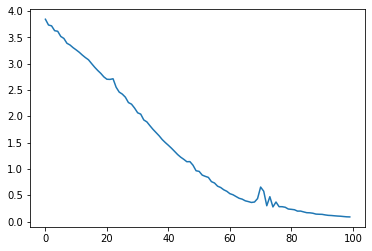

In [536]:
"""
A good test of a new model is to see that it can overfit a single batch of input. Try it, the loss should quickly go to zero:
"""

test_train_losses = []
for n in range(100):
    print(".", end="")
    train_step_logs = test_trainer.train_step([example_input_batch, example_target_batch])
    test_train_losses.append(train_step_logs["batch_loss"].numpy())
print()
plt.plot(test_train_losses)

### Finally, train the model

In [540]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, metric_key):
        self.metric_key = metric_key
        self.logs = []
    
    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.metric_key])

In [546]:
translator_model_trainer = TrainTranslatorModel(
    embedding_dim=embedding_dim,
    layer_units=layer_units,
    input_text_pre_processor=input_text_pre_processor,
    output_text_pre_processor=output_text_pre_processor,
    use_tf_function=True
)

translator_model_trainer.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss()
)

batch_loss = BatchLogs("batch_loss")

translator_model_trainer.fit(
    x=dataset,
    epochs=3,
    callbacks=[batch_loss]
)

Epoch 1/3
2164/2164 [==============================] - 725s 334ms/step - batch_loss: 1.9673
Epoch 2/3
2164/2164 [==============================] - 712s 329ms/step - batch_loss: 1.0020
Epoch 3/3
2164/2164 [==============================] - 710s 328ms/step - batch_loss: 0.7851


Text(0, 0.5, 'Cross entropy loss')

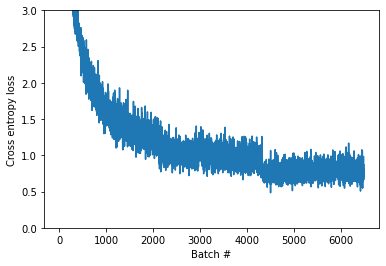

In [547]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('Cross entropy loss')

# Translate

Now that the model is trained, implement a function to execute the full text => text translation.

For this the model needs to invert the text => token IDs mapping provided by the output_text_processor. 
It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. 
The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

In [693]:
class Translator(tf.Module):
    def __init__(self, encoder, decoder, input_text_pre_processor, output_text_pre_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_pre_processor = input_text_pre_processor
        self.output_text_pre_processor = output_text_pre_processor
    
        self.output_token_string_from_id = tf.keras.layers.StringLookup(
            vocabulary=output_text_pre_processor.get_vocabulary(),
            mask_token="", # a.k.a. "padding token"
            invert=True # when true maps integers (IDs) to strings (output tokens)
        )
        
        # The actual post processed translation output should not generate padding, unknown, or start, so 
        # we will make a token mask here that masks all unwanted tokens from output.
        # The mask will be used to mask the output logits of a prediction at each timestep.
        output_token_id_from_string = tf.keras.layers.String = tf.keras.layers.StringLookup(
            vocabulary=output_text_pre_processor.get_vocabulary(),
            mask_token=""
        )
        special_token_ids = output_token_id_from_string(["", "[UNK]", "[START]"]).numpy()
        
        token_mask = np.zeros((1, 1, output_token_id_from_string.vocabulary_size()), dtype=np.bool) # dims: batch, dec_idx, dec_vocab_size
        token_mask[0, 0, np.array(special_token_ids)] = True
        self.token_mask = token_mask
        
        self.start_token = output_token_id_from_string(tf.constant("[START]"))
        self.end_token = output_token_id_from_string(tf.constant("[END]"))
    
    """
    1) Convert token IDs to text

    The first method to implement is tokens_to_text which converts from token IDs to human readable text.
    """
    def token_ids_to_text(self, result_token_ids):
        shape_checker = ShapeChecker()
        shape_checker(result_token_ids, ("batch", "dec_idx"))
        
        result_text_tokens = self.output_token_string_from_id(result_token_ids)
        shape_checker(result_text_tokens, ("batch", "dec_idx"))
        
        result_text = tf.strings.reduce_join(result_text_tokens, axis=-1, separator=" ")
        shape_checker(result_text, ("batch"))
        
        result_text = tf.strings.strip(result_text)
        shape_checker(result_text, ("batch"))
        
        return result_text
    
    """
    2) Sample from the decoder's predictions
    
    This function takes the decoder's logit outputs and samples token IDs from that distribution:
    """
    def sample(self, logits, temp):
        shape_checker = ShapeChecker()
        
        # dec_idx is usually of size 1 here since we will sample the next token at each timestep.
        shape_checker(logits, ("batch", "dec_idx", "dec_vocab_size"))
        
        # Set the logits for all padding tokens to -inf, so they are never chosen.
        shape_checker(self.token_mask, ("batch", "dec_idx", "dec_vocab_size"), broadcast=True)
        logits = tf.where(self.token_mask, -np.inf, logits)
        
        if temp == 0.0:
            new_tokens = tf.argmax(logits, axis=-1)
        else:
            logits = tf.squeeze(logits, axis=1)
            new_tokens = tf.random.categorical(
                logits=logits / temp,
                num_samples=1
            )
        
        shape_checker(new_tokens, ("batch", "dec_idx"))
        return new_tokens
    
    """
    3) Implement the translation loop (final decoding strategy (strategy being something like random sampling or beam search, rand samp w/ temp used here))
    
    Here is a complete implementation of the text to text translation loop.
    This implementation collects the results into python lists, before using tf.concat to join them into tensors.
    This implementation statically unrolls the graph out to max_length iterations. This is okay with eager execution in python.
    """
    def translate_unrolled(self,
                           input_text, *,
                           max_length=50,
                           return_attention=True,
                           temp=1.0):
        batch_size = tf.shape(input_text)[0]
        input_token_ids = self.input_text_pre_processor(input_text)
        enc_output, enc_state = self.encoder(input_token_ids)
        
        dec_state = enc_state
        new_tokens = tf.fill((batch_size, 1), self.start_token)
        
        result_tokens = []
        attention = []
        done = tf.zeros((batch_size, 1), dtype=tf.bool)
        
        for _ in range(max_length):
            dec_input = DecoderInput(
                new_tokens=new_tokens,
                enc_output=enc_output,
                mask=input_token_ids != 0
            )
            
            dec_output, dec_state = self.decoder(dec_input, state=dec_state)
            attention.append(dec_output.attention_weights)
            
            new_tokens = self.sample(dec_output.logits, temp)
            
            # If a seq produces an "[END]" token set that translation as done
            done = done | (new_tokens == self.end_token)
            
            # Once a translation seq is done only 0-padding will be added.
            new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
            
            # Collect the generated tokens.
            result_tokens.append(new_tokens)
            
            if tf.executing_eagerly() and tf.reduce_all(done):
                break
            
        # Convert the list of generated token ids to a list of strings.
        result_token_ids = tf.concat(result_tokens, axis=-1)
        result_text = self.token_ids_to_text(result_token_ids)
        
        if return_attention:
            attention_stack = tf.concat(attention, axis=1)
            return {"text": result_text, "attention": attention_stack}
        else:
            return {"text": result_text}

In [694]:
translator = Translator(
    encoder=translator_model_trainer.encoder,
    decoder=translator_model_trainer.decoder, 
    input_text_pre_processor=translator_model_trainer.input_text_pre_processor, 
    output_text_pre_processor=translator_model_trainer.output_text_pre_processor
)

In [695]:
"""
1) Testing Translator.token_ids_to_text()
"""

# Input some random token IDs and see what it generates:
example_output_tokens = tf.random.uniform(
    shape=[5,2],
    minval=0,
    dtype=tf.int64,
    maxval=output_text_pre_processor.vocabulary_size()
)
translator.token_ids_to_text(example_output_tokens)

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'bullet band', b'scandal tightly', b'threat traffic',
       b'homesick soldiers', b'putting goats'], dtype=object)>

In [696]:
"""
2) Testing Translator.sample()
"""

# Test run this function on some random inputs:
example_logits = tf.random.normal([5, 1, output_text_pre_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temp=1)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[2257],
       [ 656],
       [3398],
       [1953],
       [ 120]], dtype=int64)>

In [697]:
%%time

"""
3) Testing Translator.translate_unrolled()
"""

# Run translator on a simple input:
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = translator.translate_unrolled(input_text=input_text)
print(result["text"][0].numpy())
print(result["text"][1].numpy())

b'im very cold here .'
b'this is my life .'
Wall time: 107 ms


In [647]:
"""
If you want to export this model you'll need to wrap this method in a tf.function. 

This basic implementation has a few issues if you try to do that:
- The resulting graphs are very large and take a few seconds to build, save or load.
- You can't break from a statically unrolled loop (since we are using standard python range() op), so it will always run max_length iterations,
  even if all the outputs are done. But even then it's marginally faster than eager execution.
"""

@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate_unrolled(self, input_text):
    return self.translate_unrolled(input_text)
Translator.tf_translate_unrolled = tf_translate_unrolled

In [649]:
%%time
# Run the tf.function once to compile it:
result = translator.tf_translate_unrolled(
    input_text = input_text)

Wall time: 10.8 s


In [659]:
%%time
result = translator.tf_translate_unrolled(
    input_text = input_text)
print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its a great cold here .
this is my life .

Wall time: 121 ms


In [698]:
"""
[Optional] Use a symbolic loop

The initial implementation used python lists to collect the outputs. This uses tf.range as the loop iterator, allowing tf.autograph to convert the loop. 
The biggest change in this implementation is the use of tf.TensorArray instead of python list to accumulate tensors. tf.TensorArray is required to collect a variable number of tensors in graph mode.

With eager execution this implementation performs on par with the original.

...

But when you wrap it in a tf.function you'll notice two differences:
1) Graph creation is much faster (~10x), since it doesn't create max_iterations copies of the model.
2) Second: The compiled function is much faster on small inputs (5x on this example), because it can break out of the loop.
"""

def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
    shape_checker = ShapeChecker()
    shape_checker(input_text, ('batch',))

    batch_size = tf.shape(input_text)[0]

    # Encode the input
    input_tokens = self.input_text_pre_processor(input_text)
    shape_checker(input_tokens, ('batch', 's'))

    enc_output, enc_state = self.encoder(input_tokens)
    shape_checker(enc_output, ('batch', 's', 'enc_units'))
    shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    shape_checker(new_tokens, ('batch', 't1'))

    # Initialize the accumulators
    result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
    attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    shape_checker(done, ('batch', 't1'))

    for t in tf.range(max_length):
        dec_input = DecoderInput(
            new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)

        shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
        attention = attention.write(t, dec_result.attention_weights)

        new_tokens = self.sample(dec_result.logits, temperature)
        shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
        shape_checker(new_tokens, ('batch', 't1'))

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generated tokens
        result_tokens = result_tokens.write(t, new_tokens)

        if tf.reduce_all(done):
            break

    # Convert the list of generated token ids to a list of strings.
    result_tokens = result_tokens.stack()
    shape_checker(result_tokens, ('t', 'batch', 't0'))
    result_tokens = tf.squeeze(result_tokens, -1)
    result_tokens = tf.transpose(result_tokens, [1, 0])
    shape_checker(result_tokens, ('batch', 't'))

    result_text = self.token_ids_to_text(result_tokens)
    shape_checker(result_text, ('batch',))

    if return_attention:
        attention_stack = attention.stack()
        shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

        attention_stack = tf.squeeze(attention_stack, 2)
        shape_checker(attention_stack, ('t', 'batch', 's'))

        attention_stack = tf.transpose(attention_stack, [1, 0, 2])
        shape_checker(attention_stack, ('batch', 't', 's'))

        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}
    
Translator.translate_symbolic = translate_symbolic

@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate_symbolic(self, input_text):
    return self.translate_symbolic(input_text)

Translator.tf_translate_symbolic = tf_translate_symbolic

In [699]:
%%time
# compile first
result = translator.tf_translate_symbolic(input_text = input_text)

Wall time: 1.02 s


In [701]:
%%time
result = translator.tf_translate_symbolic(input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

im very cold .
this is my life .

Wall time: 23 ms


In [702]:
"""
Visualize the process.

The attention weights returned by the translate method show where the model was "looking" when it generated each output token.
So the sum of the attention over the input should return all ones:
"""

a = result["attention"][0]
print(np.sum(a, axis=-1))

[0.99999994 1.         1.         1.         1.         1.        ]


<BarContainer object of 7 artists>

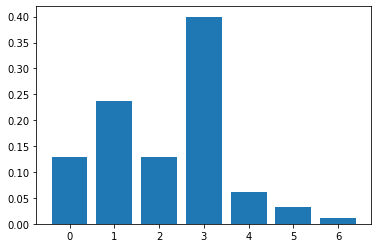

In [703]:
# Here is the attention distribution for the first output step of the first example. 
# Note how the attention is now much more focused than it was for the untrained model:
plt.bar(range(len(a[0, :])), a[0, :])

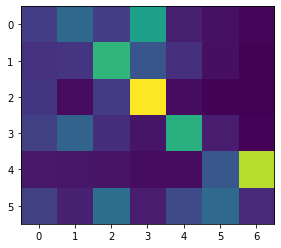

In [704]:
# Since there is some rough (soft-)alignment between the input and output words, you expect the attention to be focused near the diagonal:
plt.imshow(np.array(a), vmin=0.0)

In [705]:
"""
Labeled attention plots
"""

def plot_attention(attention, sentence, predicted_sentence):
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')

c:\python\venvs\ml_code_practice\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\python\venvs\ml_code_practice\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


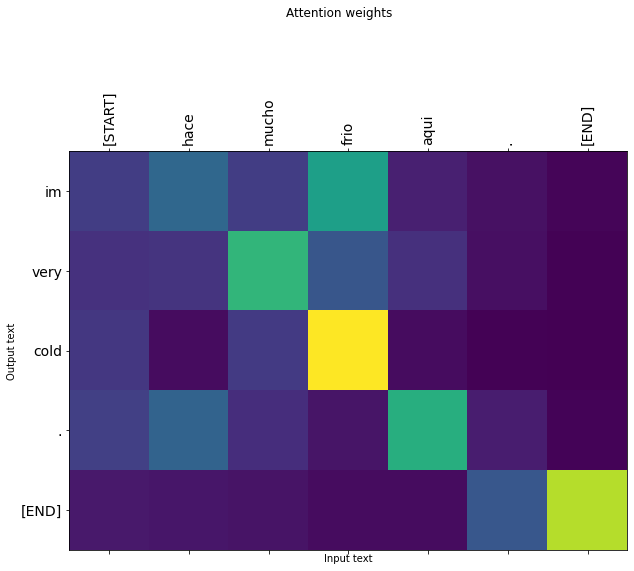

In [706]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [708]:
%%time

"""
Translate a few more sentences and plot them:
"""

three_input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])

result = translator.tf_translate_symbolic(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())

print()

this is my life .
are you still at home ?
lets try to find out .

Wall time: 28 ms


c:\python\venvs\ml_code_practice\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\python\venvs\ml_code_practice\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


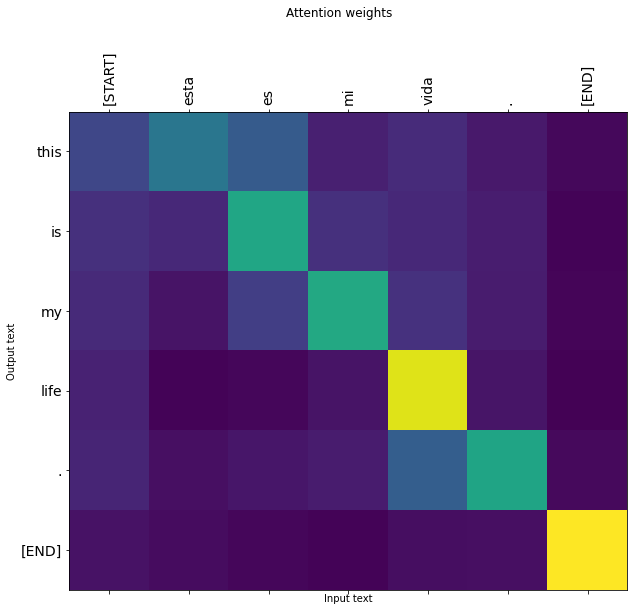

In [710]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

c:\python\venvs\ml_code_practice\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\python\venvs\ml_code_practice\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


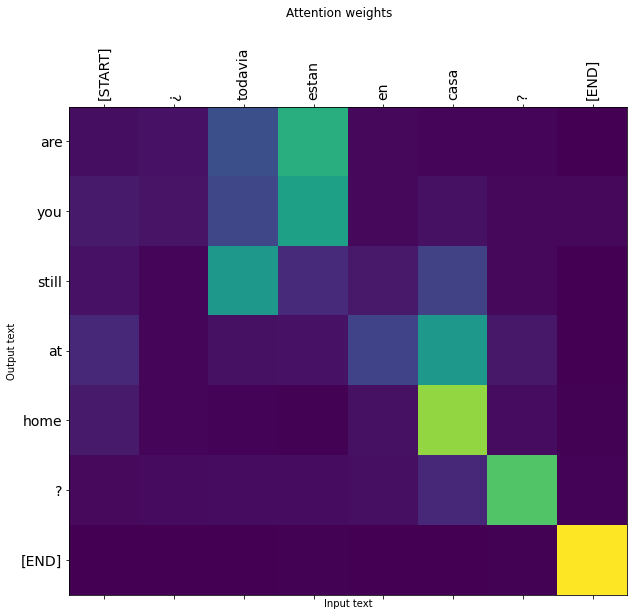

In [711]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

c:\python\venvs\ml_code_practice\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\python\venvs\ml_code_practice\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


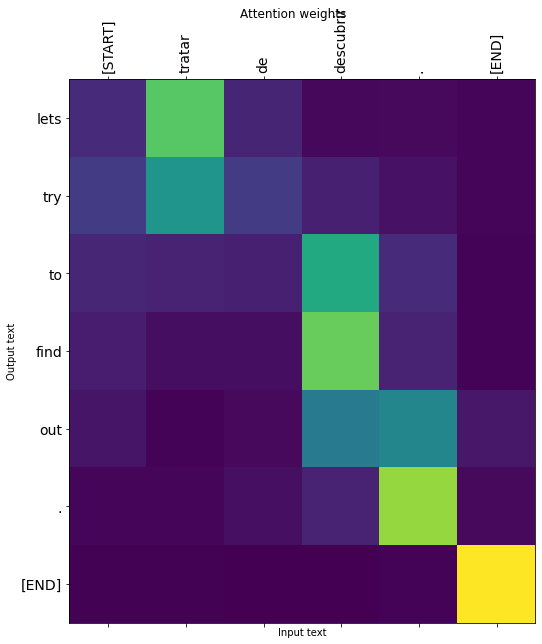

In [712]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

# Drawbacks

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:
1) The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2) The model only has access to its previous output through the RNN state. If the RNN state gets corrupted, there's no way for the model to recover. Transformers solve this by using self-attention in the encoder and decoder.

Expected output:
----------------------------------------------
One day, I woke up to find that God had put hair on my face. I shaved
it off. The next day, I found that God had put it back on my face, so
I shaved it off again. On the third day, when I found that God had put
hair back on my face again, I decided to let God have his way. That's
why I have a beard.



c:\python\venvs\ml_code_practice\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\python\venvs\ml_code_practice\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


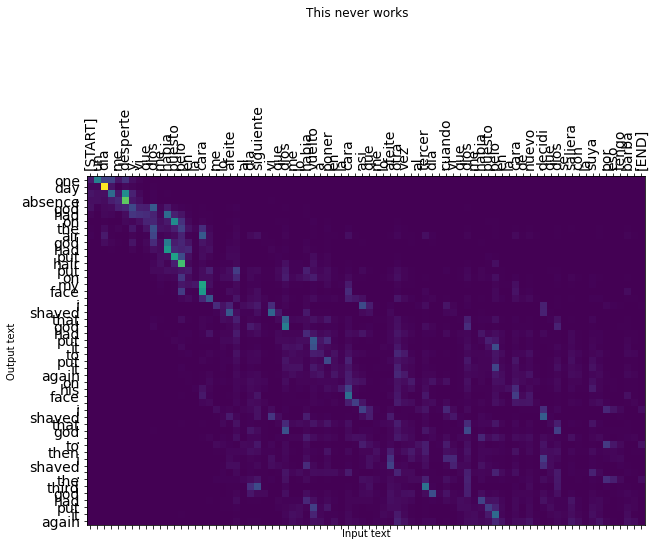

In [722]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n----------------------------------------------\n', 
      '\n'.join(textwrap.wrap(targ[-1])), 
      "\n", sep="")

result = translator.tf_translate_symbolic(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

# Export

Once you have a model you're satisfied with you might want to export it as a tf.saved_model for use outside of this python program that created it.

Since the model is a subclass of tf.Module (through keras.Model), and all the functionality for export is compiled in a tf.function the model should export cleanly with tf.saved_model.save:

Now that the function has been traced it can be exported using saved_model.save:

In [728]:
model_name = "translator.model"
tf.saved_model.save(translator, 
                    model_name,
                    signatures={"serving_default": translator.tf_translate_symbolic})

INFO:tensorflow:Assets written to: translator.model\assets


INFO:tensorflow:Assets written to: translator.model\assets


In [731]:
reloaded_translator = tf.saved_model.load(model_name)

In [732]:
%%time
result = reloaded_translator.tf_translate_symbolic(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())

print()

this is my life .
are you still at home ?
try to find out .

Wall time: 255 ms
